In [2]:
!pip install kaggle

In [4]:
!kaggle datasets download -d anubhab098/cat-vs-dog-dataset

Dataset URL: https://www.kaggle.com/datasets/anubhab098/cat-vs-dog-dataset
License(s): apache-2.0
 89% 483M/545M [00:02<00:00, 163MB/s]
100% 545M/545M [00:02<00:00, 210MB/s]


In [5]:
!unzip -q cat-vs-dog-dataset.zip

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, regularizers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [6]:
# generators - sending batches to model (rather than sending the whole dataset)

train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred', # keras will automatically create labels for the dataset cat1, cat2 and so on
    label_mode = 'int', # cats will be 0 and dog will be 1
    batch_size = 32, # considering 32 images in one batch
    image_size = (256, 256), # image size restructure if they may differ
    validation_split=0.2, # 20% of the data will be used for validation
    subset='training', # training set
    seed=123 # determinist and same split also prevents data leakage
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred', # keras will automatically create labels for the dataset cat1, cat2 and so on
    label_mode = 'int', # cats will be 0 and dog will be 1
    batch_size = 32, # considering 32 images in one batch
    image_size = (256, 256), # image size restructure if they may differ
    validation_split=0.2, # 20% of the data will be used for validation
    subset='validation', # training set
    seed=123 # determinist and same split also prevents data leakage
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [10]:
for images, labels in train_ds.take(1):
    print(f"Images shape: {images[0].shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Image dtype: {images.dtype}")
    print(f"Label dtype: {labels.dtype}")

Images shape: (256, 256, 3)
Labels shape: (32,)
Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>


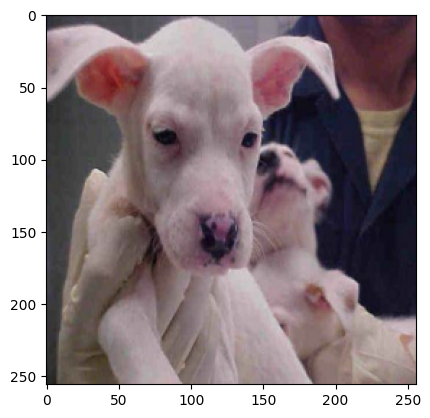

In [8]:
import matplotlib.pyplot as plt

for image, label in train_ds.take(1): # no of images wanna process
  plt.imshow(image[0].numpy().astype('uint8')) # image[0] - first image in that batch whereas uint8 is unsigned 8Bit Integer values range(0-255)
  #plt.title(f'{train_ds.class_names[label[0].numpy()]}')
  plt.show()

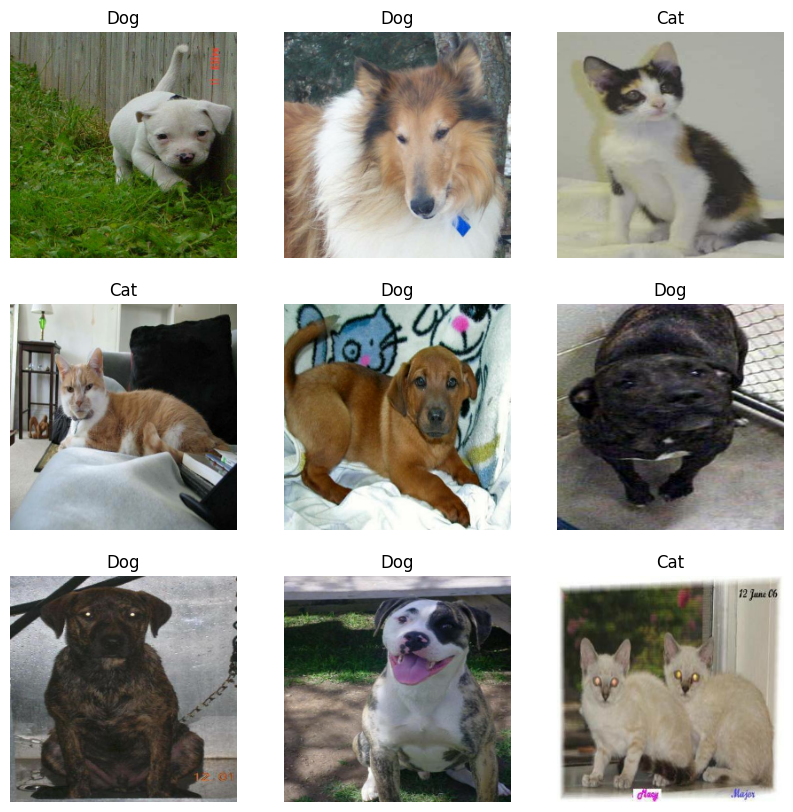

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")


In [11]:
# Normalizing the dataset

def process(image, label):
  image = tf.cast(image/255.,tf.float32)
  label = tf.cast(label,tf.int32)
  return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

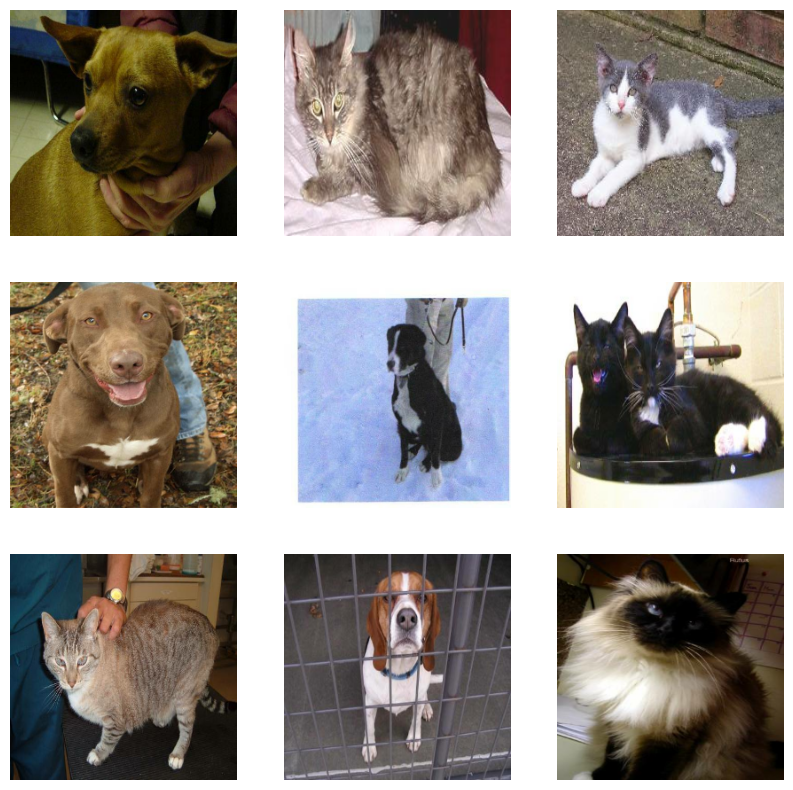

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("float32"))
        #plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [14]:
# create a CNN model

model = Sequential()

# Convulational Layer
model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3))) #(254, 254, 32) [TP =896]
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')) # (127, 127, 32)

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu')) # (125, 125, 64) [TP=1792]
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')) # (62, 62, 64)

model.add(Conv2D(128, kernel_size=(3,3),padding='valid', activation='relu')) # (60, 60, 128) [TP=3584]
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')) # (30, 30, 128)

model.add(Flatten()) # (1,15,200)

# Full Connected Layer
model.add(Dense(128, activation='relu')) # total weights here (14,745,600 + 128)
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu')) # (8192+ 64)
model.add(Dropout(0.1))

# Output Layer
model.add(Dense(1, activation='sigmoid')) # total weights here (14,745,600)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 93ms/step - accuracy: 0.6462 - loss: 0.8410 - val_accuracy: 0.7226 - val_loss: 0.5714
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.7652 - loss: 0.5062 - val_accuracy: 0.7504 - val_loss: 0.6701
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.8361 - loss: 0.3835 - val_accuracy: 0.7752 - val_loss: 0.6302
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.8838 - loss: 0.2752 - val_accuracy: 0.7988 - val_loss: 0.6065
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9265 - loss: 0.1866 - val_accuracy: 0.7954 - val_loss: 0.8027
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.9552 - loss: 0.1239 - val_accuracy: 0.8034 - val_loss: 0.7716
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.9727 - loss: 0.0847 - val_accuracy: 0.8082 - val_loss: 1.1739
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9766 - loss: 0.0685 - 

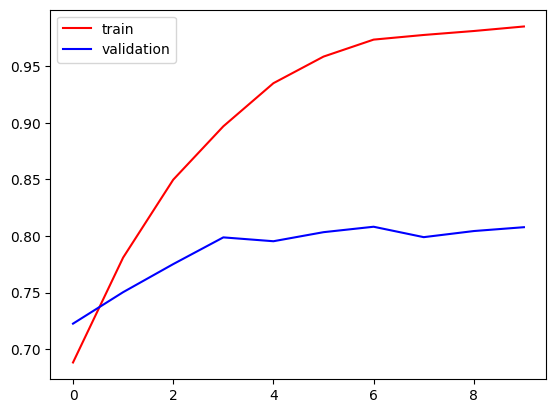

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

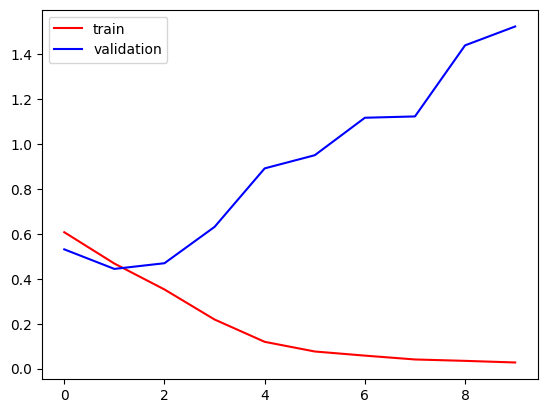

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

    Clearly seen to be case of overfitting, Let's try out various steps to overcome the same.
  

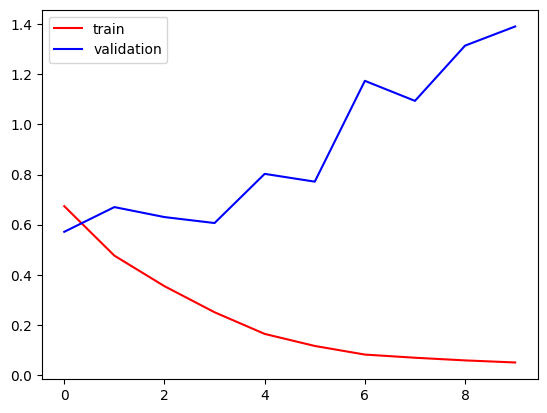

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

In [27]:
# with l2 regularizer , batch normalization
model = Sequential()

# Convulational Layer
model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3), kernel_regularizer=regularizers.l2(0.001))) #(254, 254, 32) [TP =896]
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')) # (127, 127, 32)

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu', kernel_regularizer=regularizers.l2(0.001))) # (125, 125, 64) [TP=1792]
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')) # (62, 62, 64)
model.add(Dropout(0.1))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu', kernel_regularizer=regularizers.l2(0.001))) # (125, 125, 64) [TP=1792]
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3,3),padding='valid', activation='relu', kernel_regularizer=regularizers.l2(0.001))) # (60, 60, 128) [TP=3584]
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')) # (30, 30, 128)
model.add(Dropout(0.1))

model.add(Flatten()) # (1,15,200)

# Full Connected Layer
model.add(Dense(128, activation='relu')) # total weights here (14,745,600 + 128)
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu')) # (8192+ 64)
model.add(Dropout(0.1))

# Output Layer
model.add(Dense(1, activation='sigmoid')) # total weights here (14,745,600)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.compile(optimizer=keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [32]:
history88 = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.9729 - loss: 0.1760 - val_accuracy: 0.8736 - val_loss: 0.5803
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 0.9750 - loss: 0.1678 - val_accuracy: 0.8796 - val_loss: 0.5580
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 84ms/step - accuracy: 0.9752 - loss: 0.1636 - val_accuracy: 0.8772 - val_loss: 0.5479
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - accuracy: 0.9818 - loss: 0.1468 - val_accuracy: 0.8656 - val_loss: 0.7600
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.9785 - loss: 0.1489 - val_accuracy: 0.8548 - val_loss: 0.7316
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - accuracy: 0.9816 - loss: 0.1367 - val_accuracy: 0.8672 - val_loss: 0.7792
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9800 - loss: 0.1435 - val_accuracy: 0.8852 - val_loss: 0.5889
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.9839 - loss: 0.1279 - 

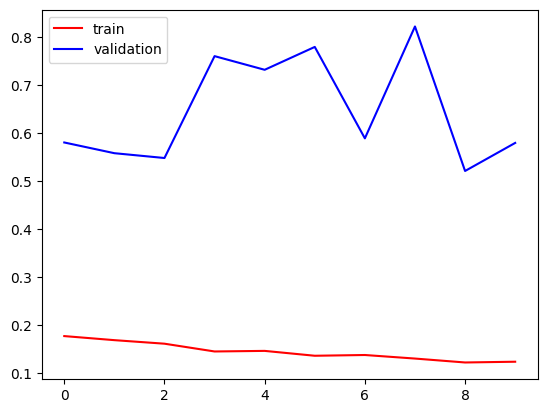

In [33]:
plt.plot(history88.history['loss'], color='red', label='train')
plt.plot(history88.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

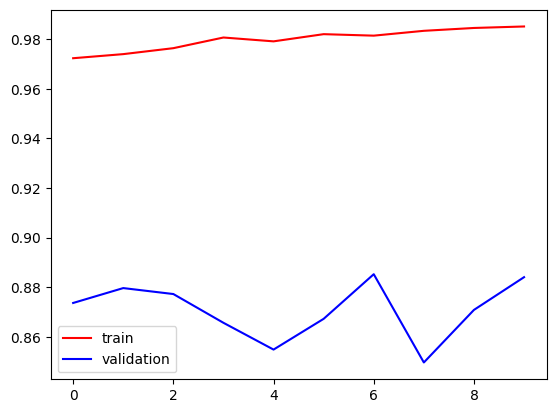

In [35]:
plt.plot(history88.history['accuracy'], color='red', label='train')
plt.plot(history88.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

In [36]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])

In [45]:
model = Sequential()

# Convulational Layer
model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3), kernel_regularizer=regularizers.l2(0.001))) #(254, 254, 32) [TP =896]
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')) # (127, 127, 32)

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu', kernel_regularizer=regularizers.l2(0.001))) # (125, 125, 64) [TP=1792]
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')) # (62, 62, 64)
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu', kernel_regularizer=regularizers.l2(0.001))) # (125, 125, 64) [TP=1792]
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3,3),padding='valid', activation='relu', kernel_regularizer=regularizers.l2(0.001))) # (60, 60, 128) [TP=3584]
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')) # (30, 30, 128)
model.add(Dropout(0.2))

model.add(Flatten()) # (1,15,200)

# Full Connected Layer
model.add(Dense(128, activation='relu')) # total weights here (14,745,600 + 128)
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu')) # (8192+ 64)
model.add(Dropout(0.1))

# Output Layer
model.add(Dense(1, activation='sigmoid')) # total weights her

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
model.compile(
    optimizer=keras.optimizers.Adam(0.0003),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [2]:
model.fit(
    train_ds,
    epochs=10,
    validation_data=validation_ds,
    callbacks=[
        keras.callbacks.EarlyStopping(
            patience=3,
            restore_best_weights=True
        )
    ]
)

NameError: name 'model' is not defined